# Visualize the camera and gelsight poses in the dataset
Given the tracking data and calibration results, we project the camera and the gelsight sensor in the world coordinate frame, together with the object

In [1]:
import sys, os
sys.path.append(os.path.dirname(os.path.abspath('')))
import os.path as osp
import numpy as np
from utils.utils import get_transform_matrix_from_quaternion, extract_camera_poses_from_json, visualize_cam_gelsight_poses_3D
from utils.camera_pose_visualizer import CameraPoseVisualizer

## Set data directory

In [2]:
# set the project directory and object dataset directory
parent_dir = os.path.dirname(os.getcwd())
obj_name = "woodbox_20240112_obj_frame" # "dumbbell_20231207_obj_frame"
obj_dir = osp.join(parent_dir, 'data', obj_name)
print(f"parent_dir: {parent_dir} \nobj_dir: {obj_dir}")

parent_dir: /data/ruihan/projects/NeRF-Texture 
obj_dir: /data/ruihan/projects/NeRF-Texture/data/woodbox_20240112_obj_frame


## (Optional) create a folder for gelsight rgb frames. for easier inspection of the dataset

In [5]:
import cv2
import matplotlib.pyplot as plt
# create a folder for gelsight rgb frames. for easier visualization
gelsight_rgb_frames_dir = osp.join(obj_dir, 'gelsight_rgb_frames')
if not osp.exists(gelsight_rgb_frames_dir):
    os.makedirs(gelsight_rgb_frames_dir)
# extract the rgb frames from npz file
gelsight_images_dir = osp.join(obj_dir, 'gelsight_images')
for npz_file in sorted(os.listdir(gelsight_images_dir)):
    if npz_file.endswith('.npz'):
        npz_file_path = osp.join(gelsight_images_dir, npz_file)
        rgb_frame = np.load(npz_file_path)['image']
        rgb_frame_path = osp.join(gelsight_rgb_frames_dir, f'{npz_file.split("_")[0]}.png')
        cv2.imwrite(rgb_frame_path, rgb_frame)
        # break

### Visualize poses in images.txt  (Before generating .json file)

Visualize 302 camera poses in world frame
Visualize 111 gelsight poses in world frame
limit for all sensor poses: x_min: -0.5643722489652823, x_max: 0.583071901046112, y_min: -0.5532568586800239, y_max: 0.5941502125444991, z_min: 0.055066012367580734, z_max: 0.3712863678110504
initialize camera pose visualizer
Save plot to logs/visualize_cam_gelsight_poses_txt_woodbox_20240112_obj_frame.png


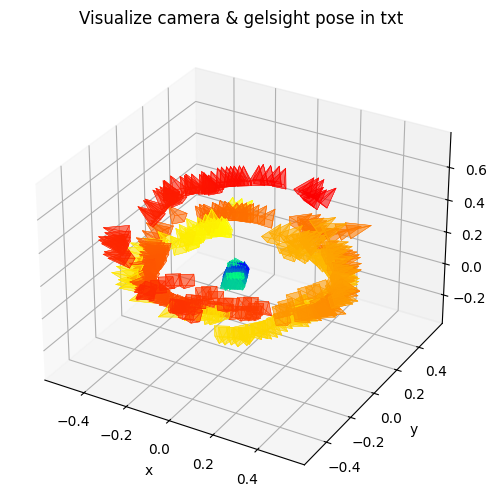

In [8]:
# Read images.txt and extract the camera poses
T_camerainworld = []
images_txt_path = osp.join(obj_dir, 'images_all.txt')
with open(images_txt_path) as f:
    images_txt = f.readlines()
    images_txt = [x.strip() for x in images_txt]
    for i in range(len(images_txt)):
        if images_txt[i].startswith('#'):
            continue
        img_id, qw, qx, qy, qz, tx, ty, tz, cam_id, img_name = images_txt[i].split(' ')
        # convert (qw, qx, qy, qz, tx, ty, tz) to homogeneous transform matrix
        quat = np.array([float(qx), float(qy), float(qz), float(qw)])
        tvec = np.array([float(tx), float(ty), float(tz)])
        # convert to homogeneous transform matrix
        T_worldincamera = get_transform_matrix_from_quaternion(tvec, quat) # [4, 4]
        cam_pose = np.linalg.inv(T_worldincamera)
        T_camerainworld.append(cam_pose)
T_camerainworld = np.array(T_camerainworld)


T_gelsightinworld = []
gelsight_images_txt_path = osp.join(obj_dir, 'gelsight_images_all.txt')
with open(gelsight_images_txt_path) as f:
    gelsight_images_txt = f.readlines()
    gelsight_images_txt = [x.strip() for x in gelsight_images_txt]
    for i in range(len(gelsight_images_txt)):
        if gelsight_images_txt[i].startswith('#'):
            continue
        img_id, qw, qx, qy, qz, tx, ty, tz, cam_id, npz_name = gelsight_images_txt[i].split(' ')
        # convert (qw, qx, qy, qz, tx, ty, tz) to homogeneous transform matrix
        quat = np.array([float(qx), float(qy), float(qz), float(qw)])
        tvec = np.array([float(tx), float(ty), float(tz)])
        # convert to homogeneous transform matrix
        T_worldingelsight = get_transform_matrix_from_quaternion(tvec, quat) # [4, 4]
        gelsight_pose = np.linalg.inv(T_worldingelsight)
        T_gelsightinworld.append(gelsight_pose)
T_gelsightinworld = np.array(T_gelsightinworld)

visualize_cam_gelsight_poses_3D(T_camerainworld, T_gelsightinworld=T_gelsightinworld, plt_title="Visualize camera & gelsight pose in txt", save_plot=True, show_plot=True, save_path=f"logs/visualize_cam_gelsight_poses_txt_{obj_name}.png", focal_len_scaled=0.1)

### Debugging: Visualize GelSight poses in quiver to check the exact position

Note: 
* the gelsight poses are the poses of the gel pad surface, not the rigid body defined in Optitrack. 
* npz file: counter:05d_gxgy.npz. gx=gx, gy=gy, nz_mask=nz_mask, dm=dm, dm_zero=dm_zero, image=frame.
* gelsight_txt. counter, qw, qx, qy, qz, tx, ty, tz, 1, counter:05d_gxgy.npz

Thus, the GelSight poses shouldn't overlap with each other. 

In [ ]:
print(f"check T_gelsightinworld: {T_gelsightinworld.shape}") # [N, 4, 4]
visualize_cam_gelsight_poses_3D(T_camerainworld=None, T_gelsightinworld=T_gelsightinworld, plt_title="Visualize gelsight pose in txt", save_plot=True, show_plot=True, save_path=f"logs/visualize_gelsight_poses_txt_{obj_name}.png", focal_len_scaled=0.01)

In [ ]:
raise ValueError("Stop here")

# 2024.01.16 Visualize camera and gelsight poses after generating json files

In [9]:
# set the project directory and object dataset directory
parent_dir = os.path.dirname(os.getcwd())
obj_name = "woodbox_20240112_obj_frame"
obj_dir = osp.join(parent_dir, 'data', obj_name)
print(f"parent_dir: {parent_dir} \nobj_dir: {obj_dir}")

# Visualize camera poses in transforms_colmap.json
json_camera = osp.join(obj_dir, 'transforms.json')
json_gelsight = osp.join(obj_dir, 'transforms_gelsight.json')

poses_camera = extract_camera_poses_from_json(json_camera)
poses_gelsight = extract_camera_poses_from_json(json_gelsight)

# flip each pose by a transform. X-right, Y-down, Z-forward changes to X-right, Y-up, Z-backward
flip_transform = np.array([[1, 0, 0, 0],
                           [0, -1, 0, 0],
                           [0, 0, -1, 0],
                           [0, 0, 0, 1]])

print(f"poses_camera shape {poses_camera.shape}, poses_gelsight shape {poses_gelsight.shape}")

parent_dir: /data/ruihan/projects/NeRF-Texture 
obj_dir: /data/ruihan/projects/NeRF-Texture/data/woodbox_20240112_obj_frame
poses_camera shape (250, 4, 4), poses_gelsight shape (111, 4, 4)


Visualize 250 camera poses in world frame
Visualize 111 gelsight poses in world frame
limit for all sensor poses: x_min: -4.19820746324894, x_max: 4.452302039496351, y_min: -4.3493330270062005, y_max: 4.3469570190807945, z_min: 0.07537844171378418, z_max: 2.3589119764483226
initialize camera pose visualizer
Save plot to logs/visualize_cam_gelsight_poses_json_woodbox_20240112_obj_frame.png


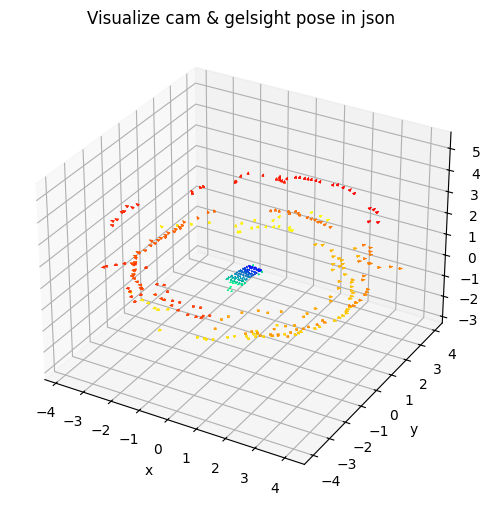

In [11]:
visualize_cam_gelsight_poses_3D(T_camerainworld=poses_camera, T_gelsightinworld=poses_gelsight, plt_title="Visualize cam & gelsight pose in json", save_plot=True, show_plot=True, flip_transform=flip_transform, save_path=f"logs/visualize_cam_gelsight_poses_json_{obj_name}.png", focal_len_scaled=0.1)